# Helping Hotels in times of flexible bookings

As the pandemic has changed the tourism industry customers are more and more used to flexibility options and cancellations when it comes to hotel bookings. Hotels are therefore offering their customers more options when it comes to changing and cancelling an existing booking. However, this imposes cost to a hotel business, as rooms are reserved for a long time and then might be cancelled shortly in advance. This short time is often not enough to find a new, paying customer for the hotel room. 

Therefore hotels might use a concept that is already prevailent in airlines: Overbooking the rooms they actually have. By accepting more bookings than a hotel has rooms, it can make sure to be closer to full capacity utilization. However, this imposes the risk of not having rooms available and having to reject customers that have a reserved room. This would be a very bad situation. Therefore it can be very beneficial to build a Machine Learning model that successfully predicts whether a customer is likely to cancel their booking. That is the goal of this work. 

### Select a performance measure


### Check the assumptions

## 0. Imports & Data Access

In [1]:
import matplotlib.pyplot as plt
import missingno
import pandas as pd
import seaborn as sns
import numpy as np
import os
from datetime import timedelta

plt.style.use('seaborn')
seed = 42

In [2]:
exec_directory = os.getcwd()
main_directory = "Hotel-Booking-ML"
main_dir_path = exec_directory[:exec_directory.find(main_directory) + len(main_directory)]
raw_data_files_location = f"{main_dir_path}/data/raw"
df_all = pd.read_csv(f"{raw_data_files_location}/hotel_booking.csv")

As a first step we'll drop the columns 'reservation_status' and 'reservation_status_date' as they include information on our label. The value 'canceled' in 'reservation_status' indicates the same as 'is_canceled', this obviously information we don't need and shouldn't feed into the model.

In [3]:
df_all.drop(columns = ['reservation_status', 'reservation_status_date' ], inplace = True)

## 1. Data Exploration

In [4]:
df_all.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


<AxesSubplot:>

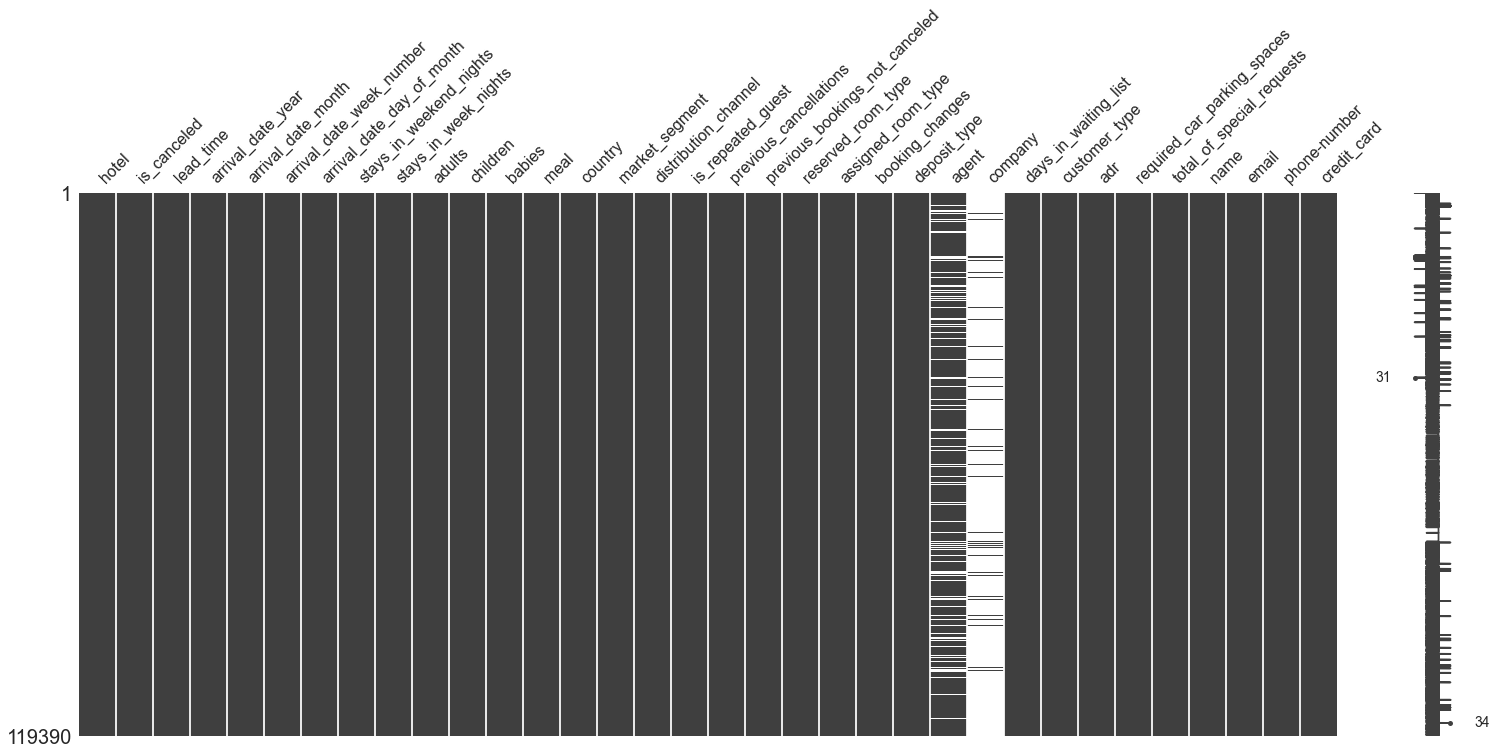

In [5]:
missingno.matrix(df_all)

#### Missing values

Luckily our dataset is complete for all features apart from agent and company. According to the data dictionary of the dataset these columns represent IDs of the agents and companies (in case of business travel) that made the bookings. Therefore it is likely that missing values do represent an information: a NA in 'company' indicates that the booking was not a business travel and a NA in 'agent' indicates that no agent was used for the booking, meaning that it was a direct booking.

Therefore we'll use OneHot encoding later on, to understand if there is a correlation between company, agent and our labels. 

#### Data transformation and aggregation. 

Before starting with the EDA we'll transform arrival and booking date to datetime format, transform the type of childern, calculate the number of total nights and retrieve the total number of guests.

In [6]:
df_all.dropna(subset=['children'], inplace=True)
df_all['children'] = df_all['children'].astype(int)
df_all = df_all.astype({"country": str})

In [7]:
# Getting arrival and booking dates right
month_mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
                         'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
df_all['arrival_date_month'] = df_all['arrival_date_month'].apply(lambda m: month_mapping[m])
df_all['arrival_date'] = pd.to_datetime(dict(year = df_all.arrival_date_year, 
                                         month = df_all.arrival_date_month, 
                                         day = df_all.arrival_date_day_of_month))
df_all['booking_date'] = df_all.apply(lambda r: r['arrival_date'] - timedelta(days=r['lead_time']), axis=1)
df_all['booking_date_day_of_week'] = df_all['booking_date'].dt.weekday

# Number of Guests
df_all['guests'] = df_all['adults'] + df_all['children'] + df_all['babies']

# Length of stay
df_all['stay_total_nights'] = df_all['stays_in_weekend_nights'] + df_all['stays_in_week_nights']

# Is Family
df_all['is_family'] = np.where((df_all['children'] >= 1) | (df_all['babies'] >= 1), 1, 0)

As a second step we split the data in a train and a test set before working on the data, because we don't want to influence our training and analysis by any information from the test set. 

In [8]:
from sklearn.model_selection import train_test_split
df, df_test = train_test_split(df_all, test_size = 0.2, random_state = seed)

## 2. Exploratory Data Analysis

We firstly split the EDA for categorical and numerical features, as we'll perform different analysis methods. 

There are two exceptions here: 
- We'll see binary variables (with 0 and 1) as a numerical feature, as it can be analyzed with the methdos we use for the 'true' numerical features.
- The 'hotel' feature discribes whether the data is for a 'City Hotel' or a 'Resort Hotel', it will be analyzed in numerical features as well. This is because we want to identify if it is worth to split the data we have according to the hotel and build separate models for each of the hotels. 

In [9]:
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,name,email,phone-number,credit_card,arrival_date,booking_date,booking_date_day_of_week,guests,stay_total_nights,is_family
67705,City Hotel,1,162,2017,5,18,6,2,1,1,...,Justin Mathis,JustinMathis@gmail.com,178-634-4195,************4817,2017-05-06,2016-11-25,4,1,3,0
115852,City Hotel,0,65,2017,7,28,10,1,1,2,...,Samantha Barr,SamanthaBarr92@zoho.com,625-113-9294,************3027,2017-07-10,2017-05-06,5,4,2,1
57349,City Hotel,1,254,2016,9,39,24,1,1,2,...,Melissa Casey,Casey.Melissa@gmail.com,905-052-7644,************6245,2016-09-24,2016-01-14,3,2,2,0
11622,Resort Hotel,1,251,2017,5,21,21,2,4,2,...,Sheila Leon,Sheila_L@hotmail.com,644-872-9073,************4034,2017-05-21,2016-09-12,0,2,6,0
33333,Resort Hotel,0,23,2017,2,7,18,1,1,2,...,Rachel Weaver,Weaver_Rachel@outlook.com,166-837-7048,************1922,2017-02-18,2017-01-26,3,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76824,City Hotel,0,3,2015,8,34,20,0,1,2,...,Kiara Collier,Kiara.C95@outlook.com,475-099-3436,************3240,2015-08-20,2015-08-17,0,3,1,1
110272,City Hotel,0,67,2017,4,16,22,2,1,2,...,Mary Jordan,Jordan_Mary42@mail.com,535-298-6559,************4866,2017-04-22,2017-02-14,1,2,3,0
103698,City Hotel,0,103,2016,12,53,27,0,3,3,...,Sarah Harris,Sarah_H34@yahoo.com,570-395-7680,************7114,2016-12-27,2016-09-15,3,3,3,0
860,Resort Hotel,1,130,2015,8,31,1,2,5,2,...,Lindsey Dennis,Lindsey.Dennis@outlook.com,105-518-9921,************1658,2015-08-01,2015-03-24,1,2,7,0


In [10]:
categorical_features = [ 'meal', 'country', 'market_segment', 'distribution_channel', 
                         'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', 'company', 
                         'customer_type']

df_num = df.drop(columns = categorical_features)

categorical_features.append('is_canceled')
df_cat = df[categorical_features]

### 2.1 Numerical features
#### 2.1.1 Correlations

First we'll take a lookt at collinearity in the data set, by pairplotting relevant features and calculating their correlations.

Please note that we are only using aggregated features here and not the features we calculated these aggregated ones on. For example, it wouldn't make sense to check for collinearity in guests with adults, children or babies as these variables are obviously correlated and won't be used side by side in the model. 

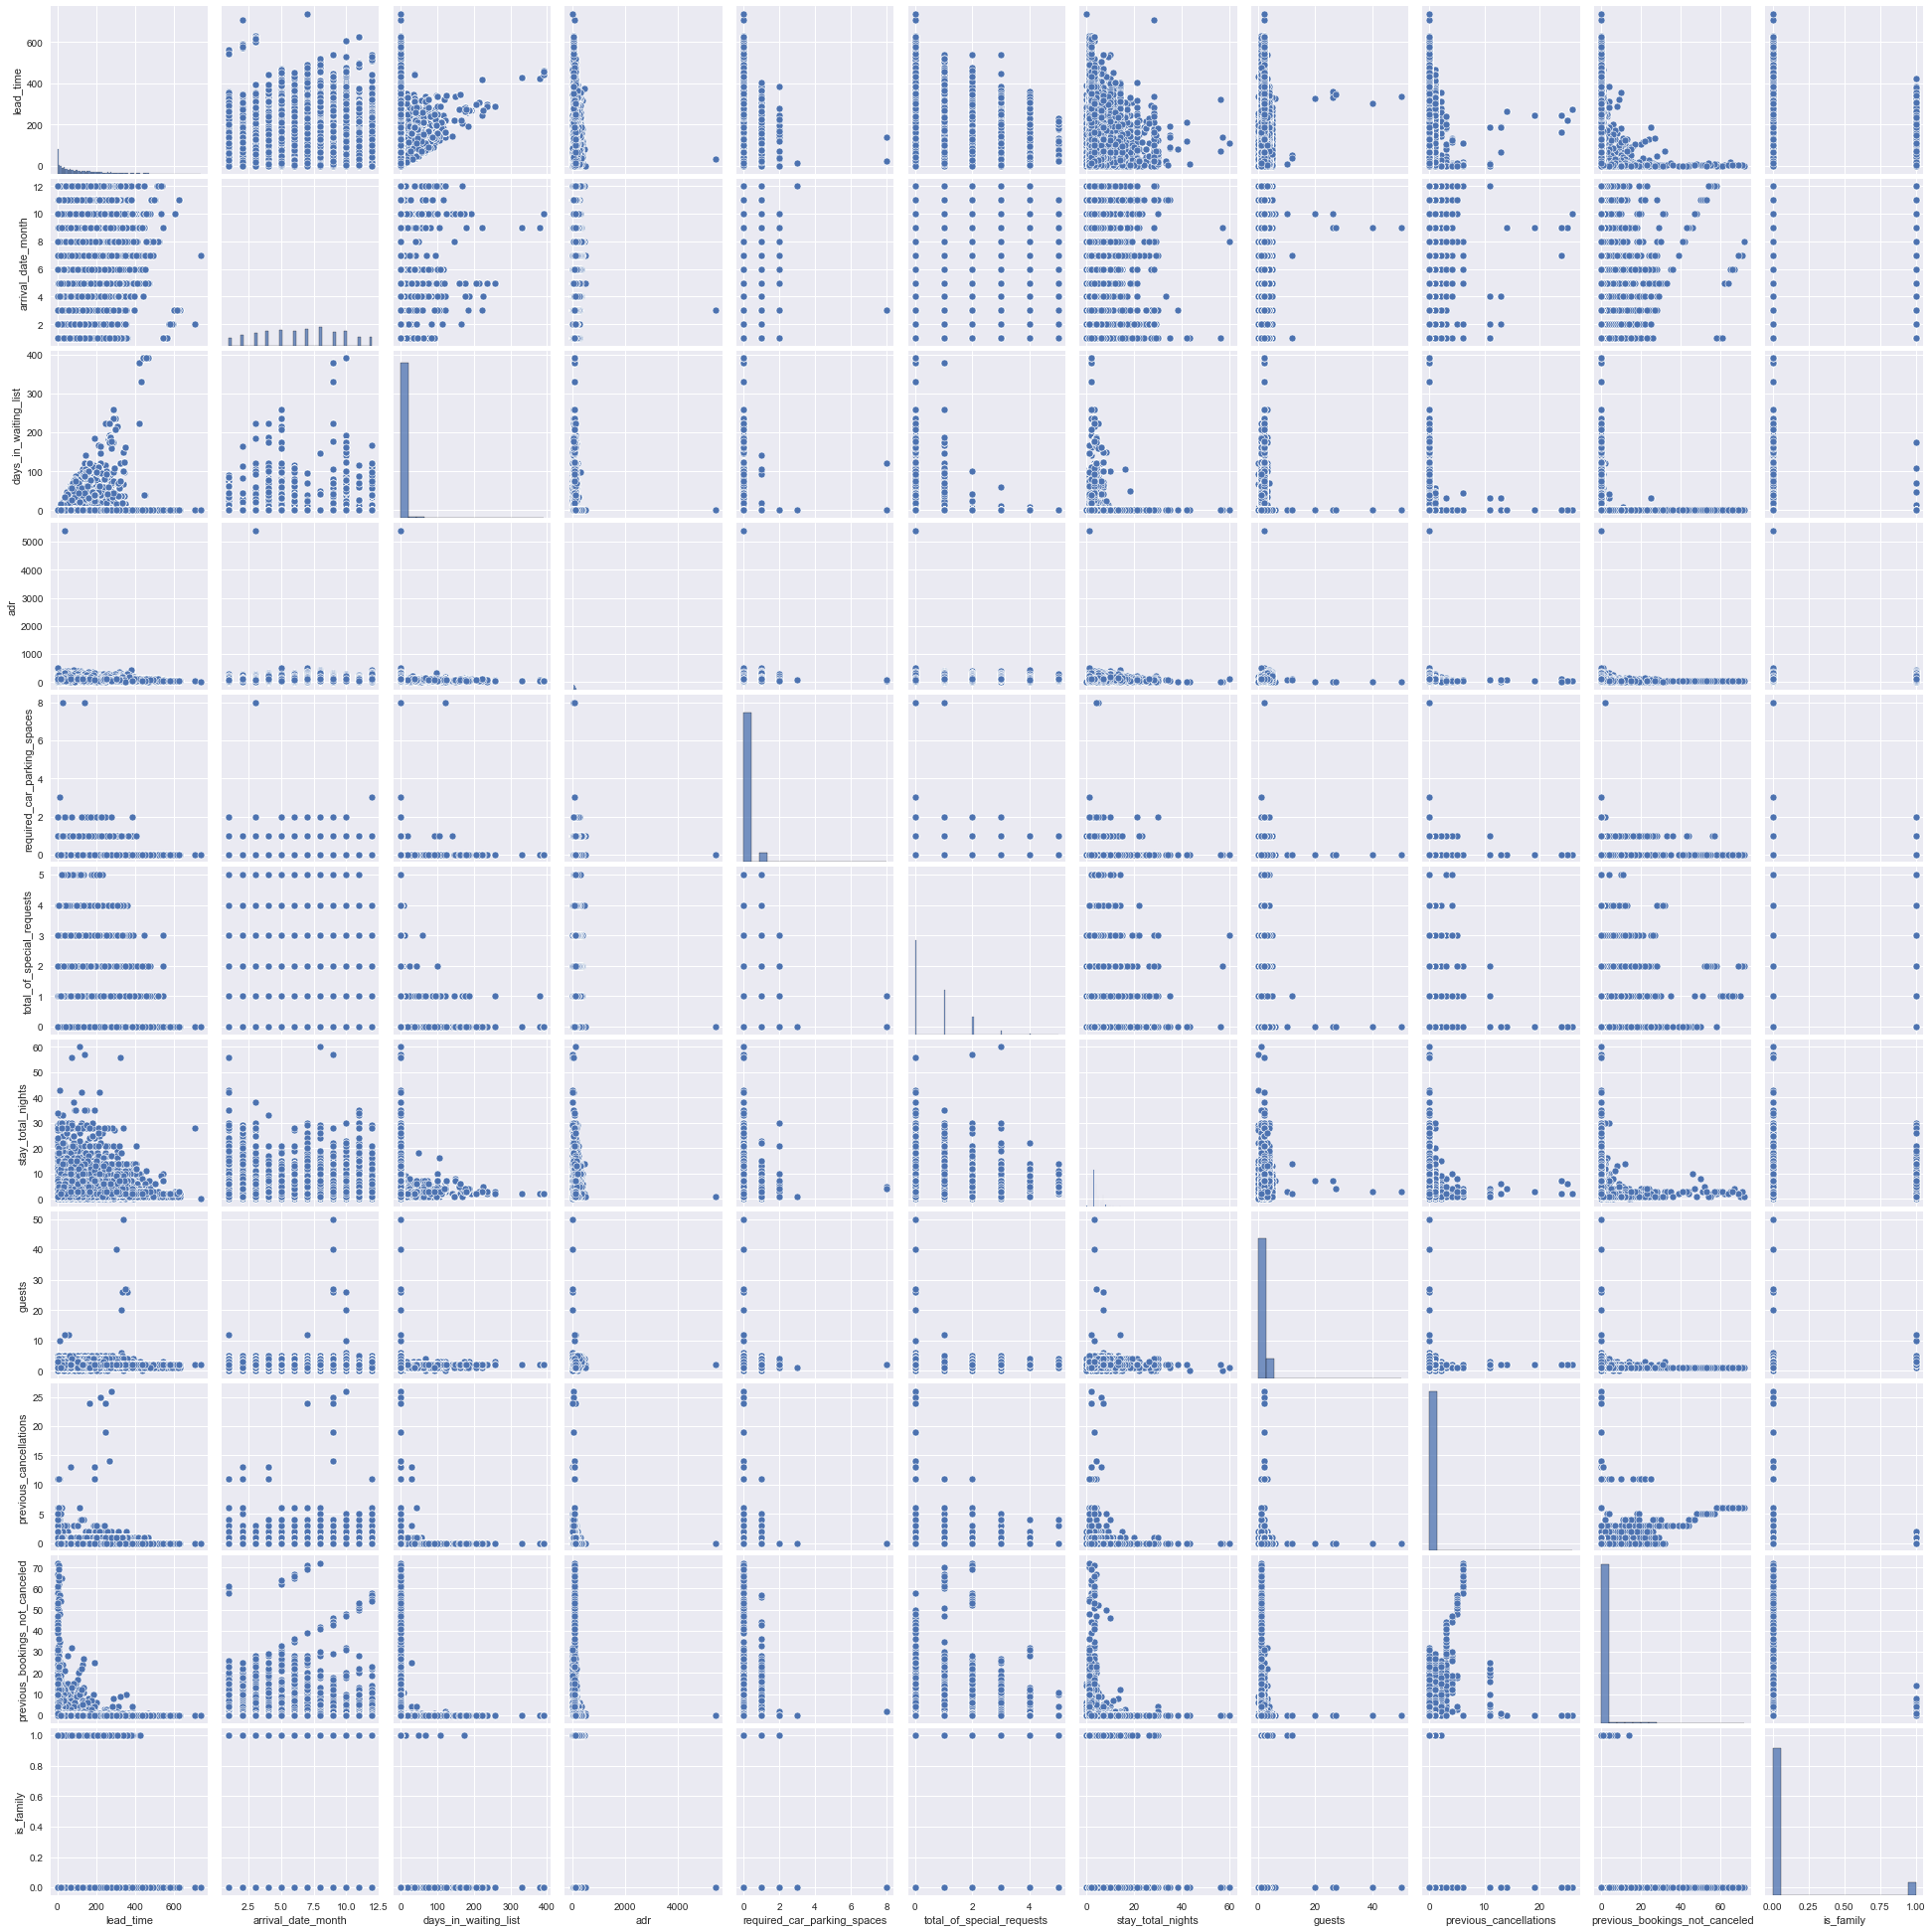

In [11]:
sns.pairplot(data=df_num[['lead_time', 'arrival_date_month','days_in_waiting_list', 'adr', 
                          'required_car_parking_spaces', 'total_of_special_requests',
                          'stay_total_nights', 'guests','previous_cancellations','previous_bookings_not_canceled','is_family']])
plt.show(sns)

In [12]:
df_corr = pd.DataFrame(df_num[['lead_time', 'arrival_date_month','days_in_waiting_list', 'adr', 
                          'required_car_parking_spaces', 'total_of_special_requests',
                          'stay_total_nights', 'guests','previous_cancellations','previous_bookings_not_canceled','is_family']].corr().unstack())
df_corr[df_corr[0] != 1].sort_values(by = 0)

,,0
lead_time,required_car_parking_spaces,-0.116711
required_car_parking_spaces,lead_time,-0.116711
previous_bookings_not_canceled,guests,-0.099201
guests,previous_bookings_not_canceled,-0.099201
lead_time,total_of_special_requests,-0.095074
...,...,...
is_family,adr,0.299004
adr,guests,0.367858
guests,adr,0.367858
is_family,guests,0.578608


The highest correlation among our features is the correlation of ADR (revenue per day) with the number of guests, this follows the logic that with the more people you stay in a hotel, the more you'll spend. When building the model we'll take a closer look if this becomes a problem. For the other features the correlations are really small and therefore no worry.  

Now, lets get the correlations of the **label** with the features, separately for the resort and city hotel to find out if they differ substiantially. This will be interesting when deciding whether to build separate models or not. 

In [13]:
correlations_all = df_num.corr()['is_canceled'].sort_values(ascending=False)
correlations_city = df_num[df_num['hotel'] == 'City Hotel'].corr()['is_canceled']
correlations_resort = df_num[df_num['hotel'] == 'Resort Hotel'].corr()['is_canceled']
correlations_df = correlations_all.to_frame().rename({'is_canceled': "All"}, axis=1)
correlations_df = correlations_df.join(correlations_city).rename({'is_canceled': "City"}, axis=1)
correlations_df = correlations_df.join(correlations_resort).rename({'is_canceled': "Resort"}, axis=1)
correlations_df

,All,City,Resort
is_canceled,1.000000,1.000000,1.000000
lead_time,0.292656,0.308682,0.228891
previous_cancellations,0.109884,0.169672,0.113671
adults,0.058182,0.050137,0.080657
days_in_waiting_list,0.053556,0.059925,-0.035325
adr,0.045862,-0.011694,0.106725
guests,0.044909,0.020516,0.103634
booking_date_day_of_week,0.034550,0.029820,0.027280
stays_in_week_nights,0.027089,0.049029,0.082916
stay_total_nights,0.019909,0.034837,0.087697


This already gives a good indication, but let's plot the data to make the difference easier to understand.

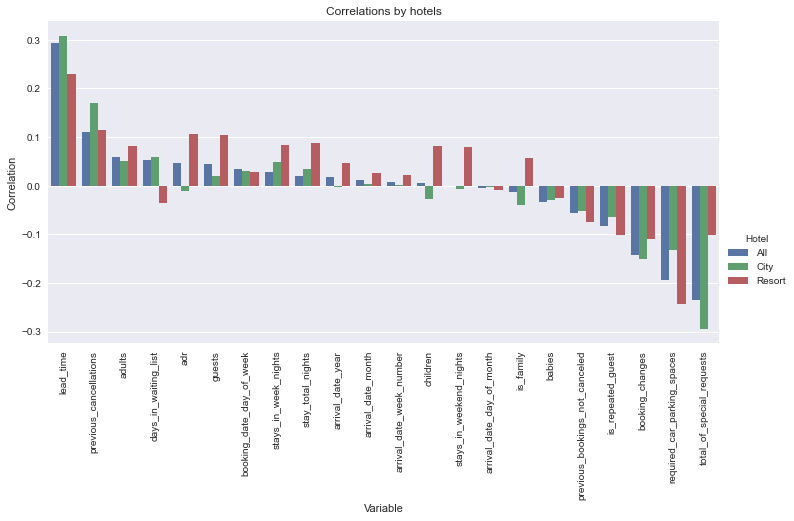

In [14]:
correlations_plot_df = pd.melt(correlations_df.drop('is_canceled'), ignore_index=False, var_name="Hotel", value_name="Correlation")
correlations_plot_df['Variable'] = correlations_plot_df.index
sns.catplot(data=correlations_plot_df, kind='bar', x='Variable', y='Correlation', hue='Hotel', aspect=2)
plt.xticks(rotation=90)
plt.title('Correlations by hotels')
plt.show()

This bar-chart shows that lead_time, previous_canellations, total_of_special_requests, required_car_parking_space and booking_changes have a correlation that is higher than 0.1 (in absolute terms). These are important candidates for our ML model later on. Additionally, the chart shows that for some features the correlation heavily depends on the kind of hotel we are looking at: For example, the number of total special requests is highly correlated with the cancellations at the city hotel, but not so much at the resort hotel. 

Based on this observation we will try out when building our first models, wether separate models or a joint model for both hotels performs better. 

As booking changes cumulates over time the dataset doesn't include the information when the last change was made, we will not use it in our model. By this we prevent information that might have appeared just days before the arrival from influencing our model whith wich we want to predict cancelations at least 7 days before (the exact number will be deiced later on). 

Some numeric variables can also be used in binary form, which could benefit the model's performance. In order to find out which option should be picked, we will look at the correlations with the target variable is_canceled. Let's first look at total_of_special requests.

In [15]:
df_corrcheck = df
df_corrcheck['any_requests'] = df_corrcheck.total_of_special_requests.apply(lambda x: 1 if x > 0 else 0)
df_corrcheck[['is_canceled', 'any_requests', 'total_of_special_requests']].corr()

,is_canceled,any_requests,total_of_special_requests
is_canceled,1.000000,-0.264282,-0.235280
any_requests,-0.264282,1.000000,0.862319
total_of_special_requests,-0.235280,0.862319,1.000000


As the binary variable any_requests is more correlated with is_canceled, we will choose this option later on. Now let's inspect previous_canellations.

In [16]:
df_corrcheck['any_cancelations'] = df_corrcheck.previous_cancellations.apply(lambda x: 1 if x > 0 else 0)
df_corrcheck[['is_canceled', 'any_cancelations', 'previous_cancellations']].corr()

,is_canceled,any_cancelations,previous_cancellations
is_canceled,1.000000,0.270280,0.109884
any_cancelations,0.270280,1.000000,0.430262
previous_cancellations,0.109884,0.430262,1.000000


This correlation is significantly higher in binary form. We will therefore use it in our model. Next up: required_car_parking_spaces.

In [17]:
df_corrcheck['any_parking'] = df_corrcheck.required_car_parking_spaces.apply(lambda x: 1 if x > 0 else 0)
df_corrcheck[['is_canceled', 'any_parking', 'required_car_parking_spaces']].corr()

,is_canceled,any_parking,required_car_parking_spaces
is_canceled,1.000000,-0.197058,-0.194928
any_parking,-0.197058,1.000000,0.989192
required_car_parking_spaces,-0.194928,0.989192,1.000000


There is only little difference between the binary and the numeric column. We will go for the binary variable to keep the model simpler.

#### 2.1.2 Frequency Distributions
# Add Descriptions here

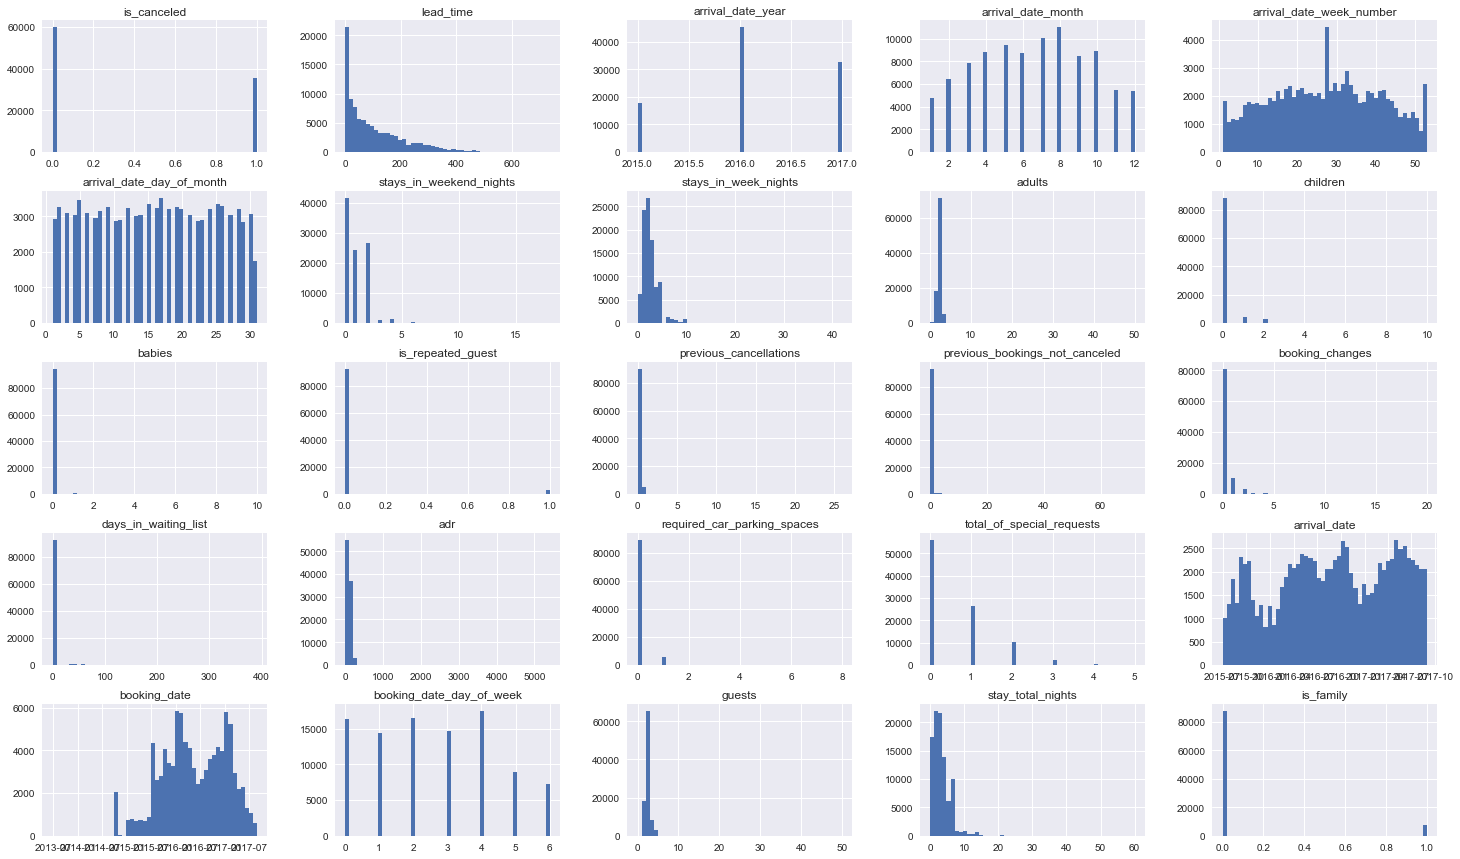

In [18]:
df_num.hist(bins=50, figsize=(25,15))
plt.show()

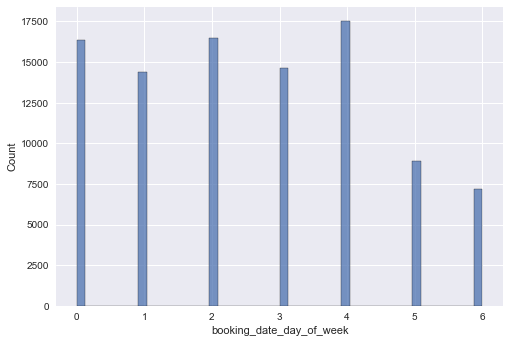

In [19]:
sns.histplot(df['booking_date_day_of_week'])
plt.show(sns)

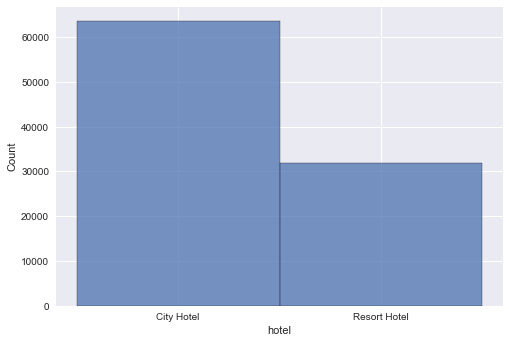

In [20]:
sns.histplot(df['hotel'])
plt.show(sns)

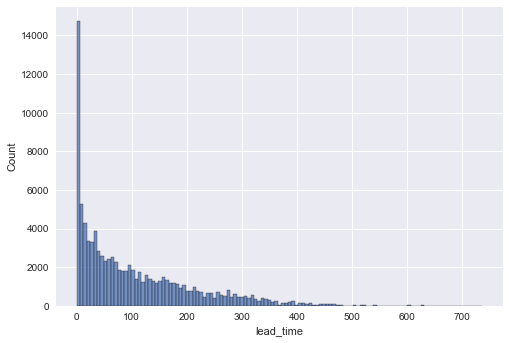

In [21]:
sns.histplot(df['lead_time'])
plt.show(sns)

### 2.2 Categorical variables

#### 2.2.1 Understanding the categories

Here we'll use df_cat, with all categorical features we have identified perviously. 

In [48]:
df_cat.columns

Index(['meal', 'country', 'market_segment', 'distribution_channel',
       'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent',
       'company', 'customer_type', 'is_canceled'],
      dtype='object')

'Company' and 'agent' are columns with ids. Let's look at the values in the other ("true") categorical variables to get a feeling for what they are. 

In [23]:
df_cat[['meal']].value_counts(normalize = True)

meal     
BB           0.773255
HB           0.121215
SC           0.089123
Undefined    0.009800
FB           0.006607
dtype: float64

In [24]:
df_cat[['country']].value_counts(normalize = True).head(10)

country
PRT        0.407013
GBR        0.101133
FRA        0.086998
ESP        0.071774
DEU        0.061063
ITA        0.031798
IRL        0.028280
BEL        0.019852
BRA        0.018763
USA        0.017674
dtype: float64

In [25]:
df_cat[['market_segment']].value_counts(normalize = True)

market_segment
Online TA         0.473667
Offline TA/TO     0.203208
Groups            0.165421
Direct            0.105017
Corporate         0.044269
Complementary     0.006418
Aviation          0.002000
dtype: float64

In [26]:
df_cat[['distribution_channel']].value_counts(normalize = True)

distribution_channel
TA/TO                   0.820549
Direct                  0.122147
Corporate               0.055650
GDS                     0.001654
dtype: float64

In [27]:
df_cat[['reserved_room_type']].value_counts(normalize = True)

reserved_room_type
A                     0.720076
D                     0.161599
E                     0.054844
F                     0.023956
G                     0.017339
B                     0.009423
C                     0.007664
H                     0.004952
P                     0.000094
L                     0.000052
dtype: float64

In [28]:
df_cat[['assigned_room_type']].value_counts(normalize = True)

assigned_room_type
A                     0.620315
D                     0.212673
E                     0.065534
F                     0.031149
G                     0.021297
C                     0.019695
B                     0.017946
H                     0.005958
I                     0.003057
K                     0.002283
P                     0.000094
dtype: float64

In [29]:
df_cat[['deposit_type']].value_counts(normalize = True)

deposit_type
No Deposit      0.876660
Non Refund      0.121916
Refundable      0.001424
dtype: float64

In [30]:
df_cat[['customer_type']].value_counts(normalize = True)

customer_type  
Transient          0.750743
Transient-Party    0.210380
Contract           0.034008
Group              0.004869
dtype: float64

Especially, the deposit type seems likely to have a high explanatory power. If you have made no deposit you are much more likely to cancel a booking than when you made a non-refundable deposit, right?

#### 2.2.2 Correlations of categorical variables with cancellations

Let's OneHot Encode the categories and IDs (for agent and company) in the next step and get their correlations with the cancellations. 

In [12]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(sparse = False)
df_cat = df_cat.sort_index().reset_index(drop = True)
df_cat_trans = pd.DataFrame(data = onehot.fit_transform(df_cat.drop(columns = 'is_canceled')),
                                columns = onehot.get_feature_names_out())

In [13]:
df_cat_trans = pd.concat([df_cat.is_canceled, df_cat_trans], axis = 1 )


Now we'll use this transformed dataframe of our categorical variables and find out how correlated they are with 'is_canceled'.

Watch out, the next cell takes quite a while to compute. 

In [16]:
df_cat_corr = df_cat_trans.corr()
df_cat_corr = df_cat_corr['is_canceled']

In [17]:
df_cat_corr.sort_values()

deposit_type_No Deposit         -0.477762
market_segment_Direct           -0.153217
distribution_channel_Direct     -0.150596
assigned_room_type_D            -0.127559
customer_type_Transient-Party   -0.125246
                                   ...   
assigned_room_type_A             0.197833
market_segment_Groups            0.221364
country_PRT                      0.336209
deposit_type_Non Refund          0.481499
is_canceled                      1.000000
Name: is_canceled, Length: 870, dtype: float64

This is gives a dataframe of **xxxx** correlations with the label. Very likely, most of them will have a very low correlation with the label. Therefore, let's only look at the ones with a correlation of more than 0.05 (positive or negative).

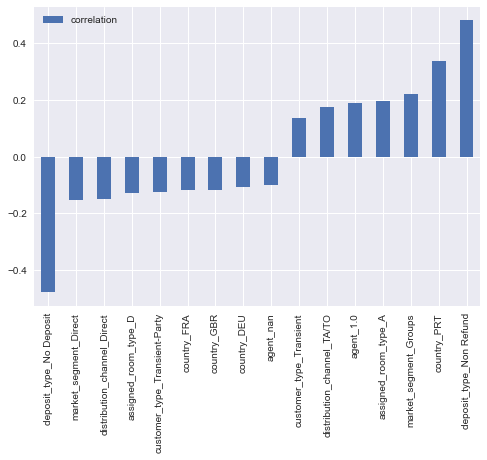

In [19]:
df_cat_corr_red = pd.DataFrame(df_cat_corr).rename({'is_canceled' : 'correlation'}, axis = 1)
df_cat_corr_red = df_cat_corr_red[(df_cat_corr_red['correlation'] >= 0.1 ) | (df_cat_corr_red['correlation'] <= -0.1) ]
df_cat_corr_red.sort_values(by = 'correlation')[:-1].plot(kind = 'bar')
plt.show()

This gives us a good indication, that especially x2 (= 'deposit_type') is likely to have a high explanatory power. But also x1 = ('Coutnry') equalling to Portugal, x2 (= 'market_segment') equalling to Groups can be important when building the model.

### 2.3 Time Series Analysis
In this section we are looking for underlying seasonality in the given cancelations and bookings.

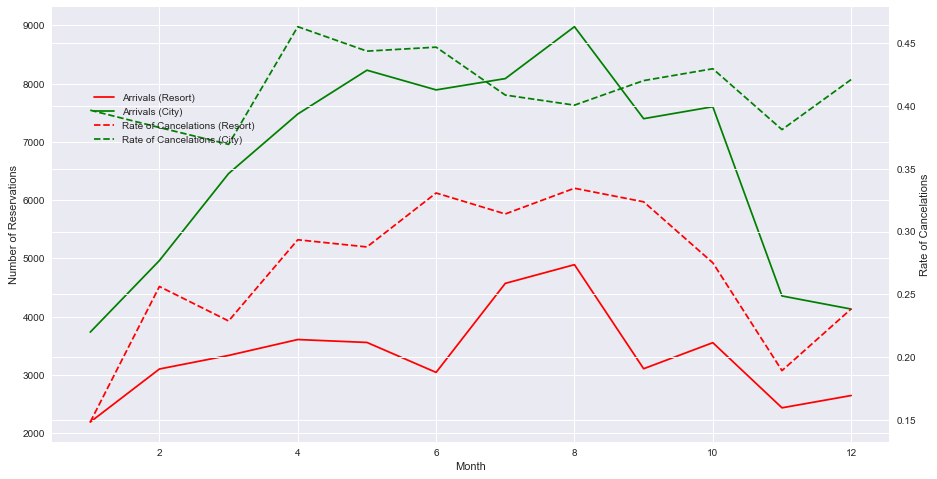

In [36]:
df_resort = df[df["hotel"] == "Resort Hotel"]
df_city = df[df["hotel"] == "City Hotel"]

#Get data for Resort Hotel
df_timeseries_r = pd.DataFrame(df_resort.groupby("arrival_date_month").size())
df_timeseries_r["Cancelations"] = df_resort.groupby("arrival_date_month")["is_canceled"].sum()
df_timeseries_r.columns = ['Arrivals', 'Cancelations']
df_timeseries_r["Cancelation_Share"] = df_timeseries_r["Cancelations"]/df_timeseries_r["Arrivals"]

#Get data for City Hotel
df_timeseries_c = pd.DataFrame(df_city.groupby("arrival_date_month").size())
df_timeseries_c["Cancelations"] = df_city.groupby("arrival_date_month")["is_canceled"].sum()
df_timeseries_c.columns = ['Arrivals', 'Cancelations']
df_timeseries_c["Cancelation_Share"] = df_timeseries_c["Cancelations"]/df_timeseries_c["Arrivals"]

#Plot linechart
fig, ax1 = plt.subplots(figsize=(15, 8))

ax1.set_xlabel("Month")
ax1.set_ylabel("Number of Reservations")
ax1.plot(
    df_timeseries_r["Arrivals"],
    color="red",
    label="Arrivals (Resort)"
)

ax1.plot(
    df_timeseries_c["Arrivals"],
    color="green",
    label="Arrivals (City)"
)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel("Rate of Cancelations")
ax2.plot(
    df_timeseries_r["Cancelation_Share"],
    color="red",
    linestyle="dashed",
    label="Rate of Cancelations (Resort)",
)

ax2.plot(
    df_timeseries_c["Cancelation_Share"],
    color="green",
    linestyle="dashed",
    label="Rate of Cancelations (City)",
)

fig.legend(loc = 2, borderaxespad=9)

Based on this plot, we can draw several conclusions:

- Bookings and cancelation-rate differs greatly between Resort and City Hotels. With City Hotels experiencing more bookings but also more cancellations.
- Cancellation rate follows the same patten as the number of bookings.
- Bookings and cancellations follow a seasonal pattern.

## 3 Model Creation
### 3.1 Preprocessing Pipeline
Based on our exploritory analyisis we discovered different features that we will include in our prediction model. The features were selected based on a correlation threshold of 0,1 with our target variable "is_canceled". This guarantees that significant features which seem to explain a hotel cancellations are added to the model. The following features will be used:

- **Numeric attributes:** "lead_time", "total_of_special_requests", "previous_cancellations", "required_car_parking_spaces"
- **Categorical attributes:** "deposit_type", "country", "market_segment".

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Binarizer, LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

In [86]:
X = pd.DataFrame(df.loc[:,["lead_time", "total_of_special_requests", "previous_cancellations", "required_car_parking_spaces","deposit_type", "country","market_segment"]]).sort_index().reset_index(drop = True)
y = pd.DataFrame(df.loc[:,'is_canceled']).sort_index().reset_index(drop = True)

#Define categories of attributes
num_attribs = ["lead_time"]
num_attribs_bin = ["total_of_special_requests", "previous_cancellations", "required_car_parking_spaces"]
cat_attribs_bin = ["deposit_type", "country", "market_segment"]

#Define function for one-vs-all binary transformation of categorical variables
def binary_tansformer_cat(column, true_value):
    X[column] = (X[column] == true_value).astype(int)

In [87]:
#For now: Please only run this step ONCE
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), num_attribs),
        ("num binary", Binarizer(), num_attribs_bin),
        ("country binary", FunctionTransformer(binary_tansformer_cat("country", "PRT"), validate = False), ["country"]),
        ("segment binary", FunctionTransformer(binary_tansformer_cat("market_segment", "Groups"), validate = False), ["market_segment"]),
        ("deposit binary", FunctionTransformer(binary_tansformer_cat("deposit_type", "Non Refund"), validate = False), ["deposit_type"])
    ])

In [88]:
#Testing the outcome
X_transformed = pd.DataFrame(preprocessor.fit_transform(X))
X_transformed

,0,1,2,3,4,5,6
0,5.918857,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.906895,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.841443,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.841443,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.972347,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
95503,0.289949,0.0,0.0,0.0,0.0,0.0,0.0
95504,0.561109,0.0,0.0,0.0,0.0,0.0,0.0
95505,-0.757289,0.0,0.0,0.0,0.0,0.0,0.0
95506,-0.018612,1.0,0.0,0.0,0.0,0.0,0.0


### 3.2 Building the first model

In [94]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV

log_reg = LogisticRegression(class_weight = 'balanced',
                             random_state = seed)

params = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 
          'solver' : ['liblinear', 'saga'],
          'penalty': ['l1', 'l2']}

RSCV = RandomizedSearchCV(log_reg, 
                            params,
                            cv = 5, 
                            scoring = 'accuracy', 
                            return_train_score = True, 
                            n_jobs = -1,
                            verbose = 4,
                         n_iter = 20)

search = RSCV.fit(X_transformed, y)
results = pd.DataFrame(search.cv_results_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/patrickgundlach/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [95]:
estimator_1 = search.best_estimator_

In [96]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def get_cnf_matrix(best_est, X, true_y):
    
    # Obtaining predicte data and building confusion matrix
    y_predicted = best_est.predict(X)
    cnf_matrix = confusion_matrix(true_y, y_predicted)

    # Plotting the confusion matrix

    class_names=[0,1]
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), 
                annot=True, 
                cmap="YlGnBu" ,
                fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')


def get_metrics(best_est, X, true_y):
    y_predicted_test = best_est.predict(X)
    # Printing the evaluation criteria
    print("Recall:", round(recall_score(true_y, y_predicted_test),4))
    print("Precision:", round(precision_score(true_y, y_predicted_test),4))
    print("Accuracy:", round(accuracy_score(true_y, y_predicted_test),4))

Recall: 0.6012
Precision: 0.6468
Accuracy: 0.7312


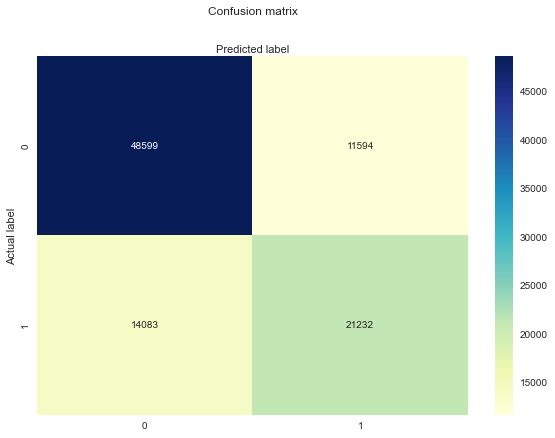

In [97]:
get_cnf_matrix(estimator_1, X_transformed, y)
get_metrics(estimator_1, X_transformed, y)

In [82]:
# Little check on test dataset:
X_test = pd.DataFrame(df_test.loc[:,["lead_time", "total_of_special_requests", "previous_cancellations", "required_car_parking_spaces","deposit_type", "country","market_segment"]]).sort_index().reset_index(drop = True)
y_test = pd.DataFrame(df_test.loc[:,'is_canceled']).sort_index().reset_index(drop = True)

X_test_transformed = pd.DataFrame(preprocessor.transform(X_test))


get_cnf_matrix(estimator_1, X_test_transformed, y_test)
get_metrics(estimator_1, X_test_transformed, y_test)

ValueError: could not convert string to float: 'PRT'

In [100]:
preprocessor.transform(X_test)

array([[2.225470850982853, 0, 0, ..., 'PRT', 'Direct', 'No Deposit'],
       [-0.8507928481242236, 0, 0, ..., 'GBR', 'Corporate', 'No Deposit'],
       [-0.2991224583147479, 1, 0, ..., 'PRT', 'Direct', 'No Deposit'],
       ...,
       [-0.7759900834042948, 1, 0, ..., 'BEL', 'Offline TA/TO',
        'No Deposit'],
       [-0.6544355907344103, 1, 0, ..., 'DEU', 'Online TA', 'No Deposit'],
       [0.9444735051540704, 1, 0, ..., 'DEU', 'Online TA', 'No Deposit']],
      dtype=object)